nodes:  50 links  69
Generation 0: Min Fitness 3896.0434748688385
Generation 1: Min Fitness 3842.5737239826285
Generation 2: Min Fitness 3842.5737239826285
Generation 3: Min Fitness 3842.5737239826285
Generation 4: Min Fitness 3831.6540292537306
Generation 5: Min Fitness 3842.5737239826285
Generation 6: Min Fitness 3777.246863748146
Generation 7: Min Fitness 3720.3726386676253
Generation 8: Min Fitness 3756.7673277865465
Generation 9: Min Fitness 3418.8416449305787
Generation 10: Min Fitness 3418.8416449305787
Generation 11: Min Fitness 3418.8416449305787
Generation 12: Min Fitness 3418.8416449305787
Generation 13: Min Fitness 3345.0028347469315
Generation 14: Min Fitness 3345.0028347469315
Generation 15: Min Fitness 3146.8036428964406
Generation 16: Min Fitness 3146.8036428964406
Generation 17: Min Fitness 3104.0673208295866
Generation 18: Min Fitness 3113.082185290361
Generation 19: Min Fitness 3092.7264826114465
Generation 20: Min Fitness 3067.1300840226395
Generation 21: Min Fitnes

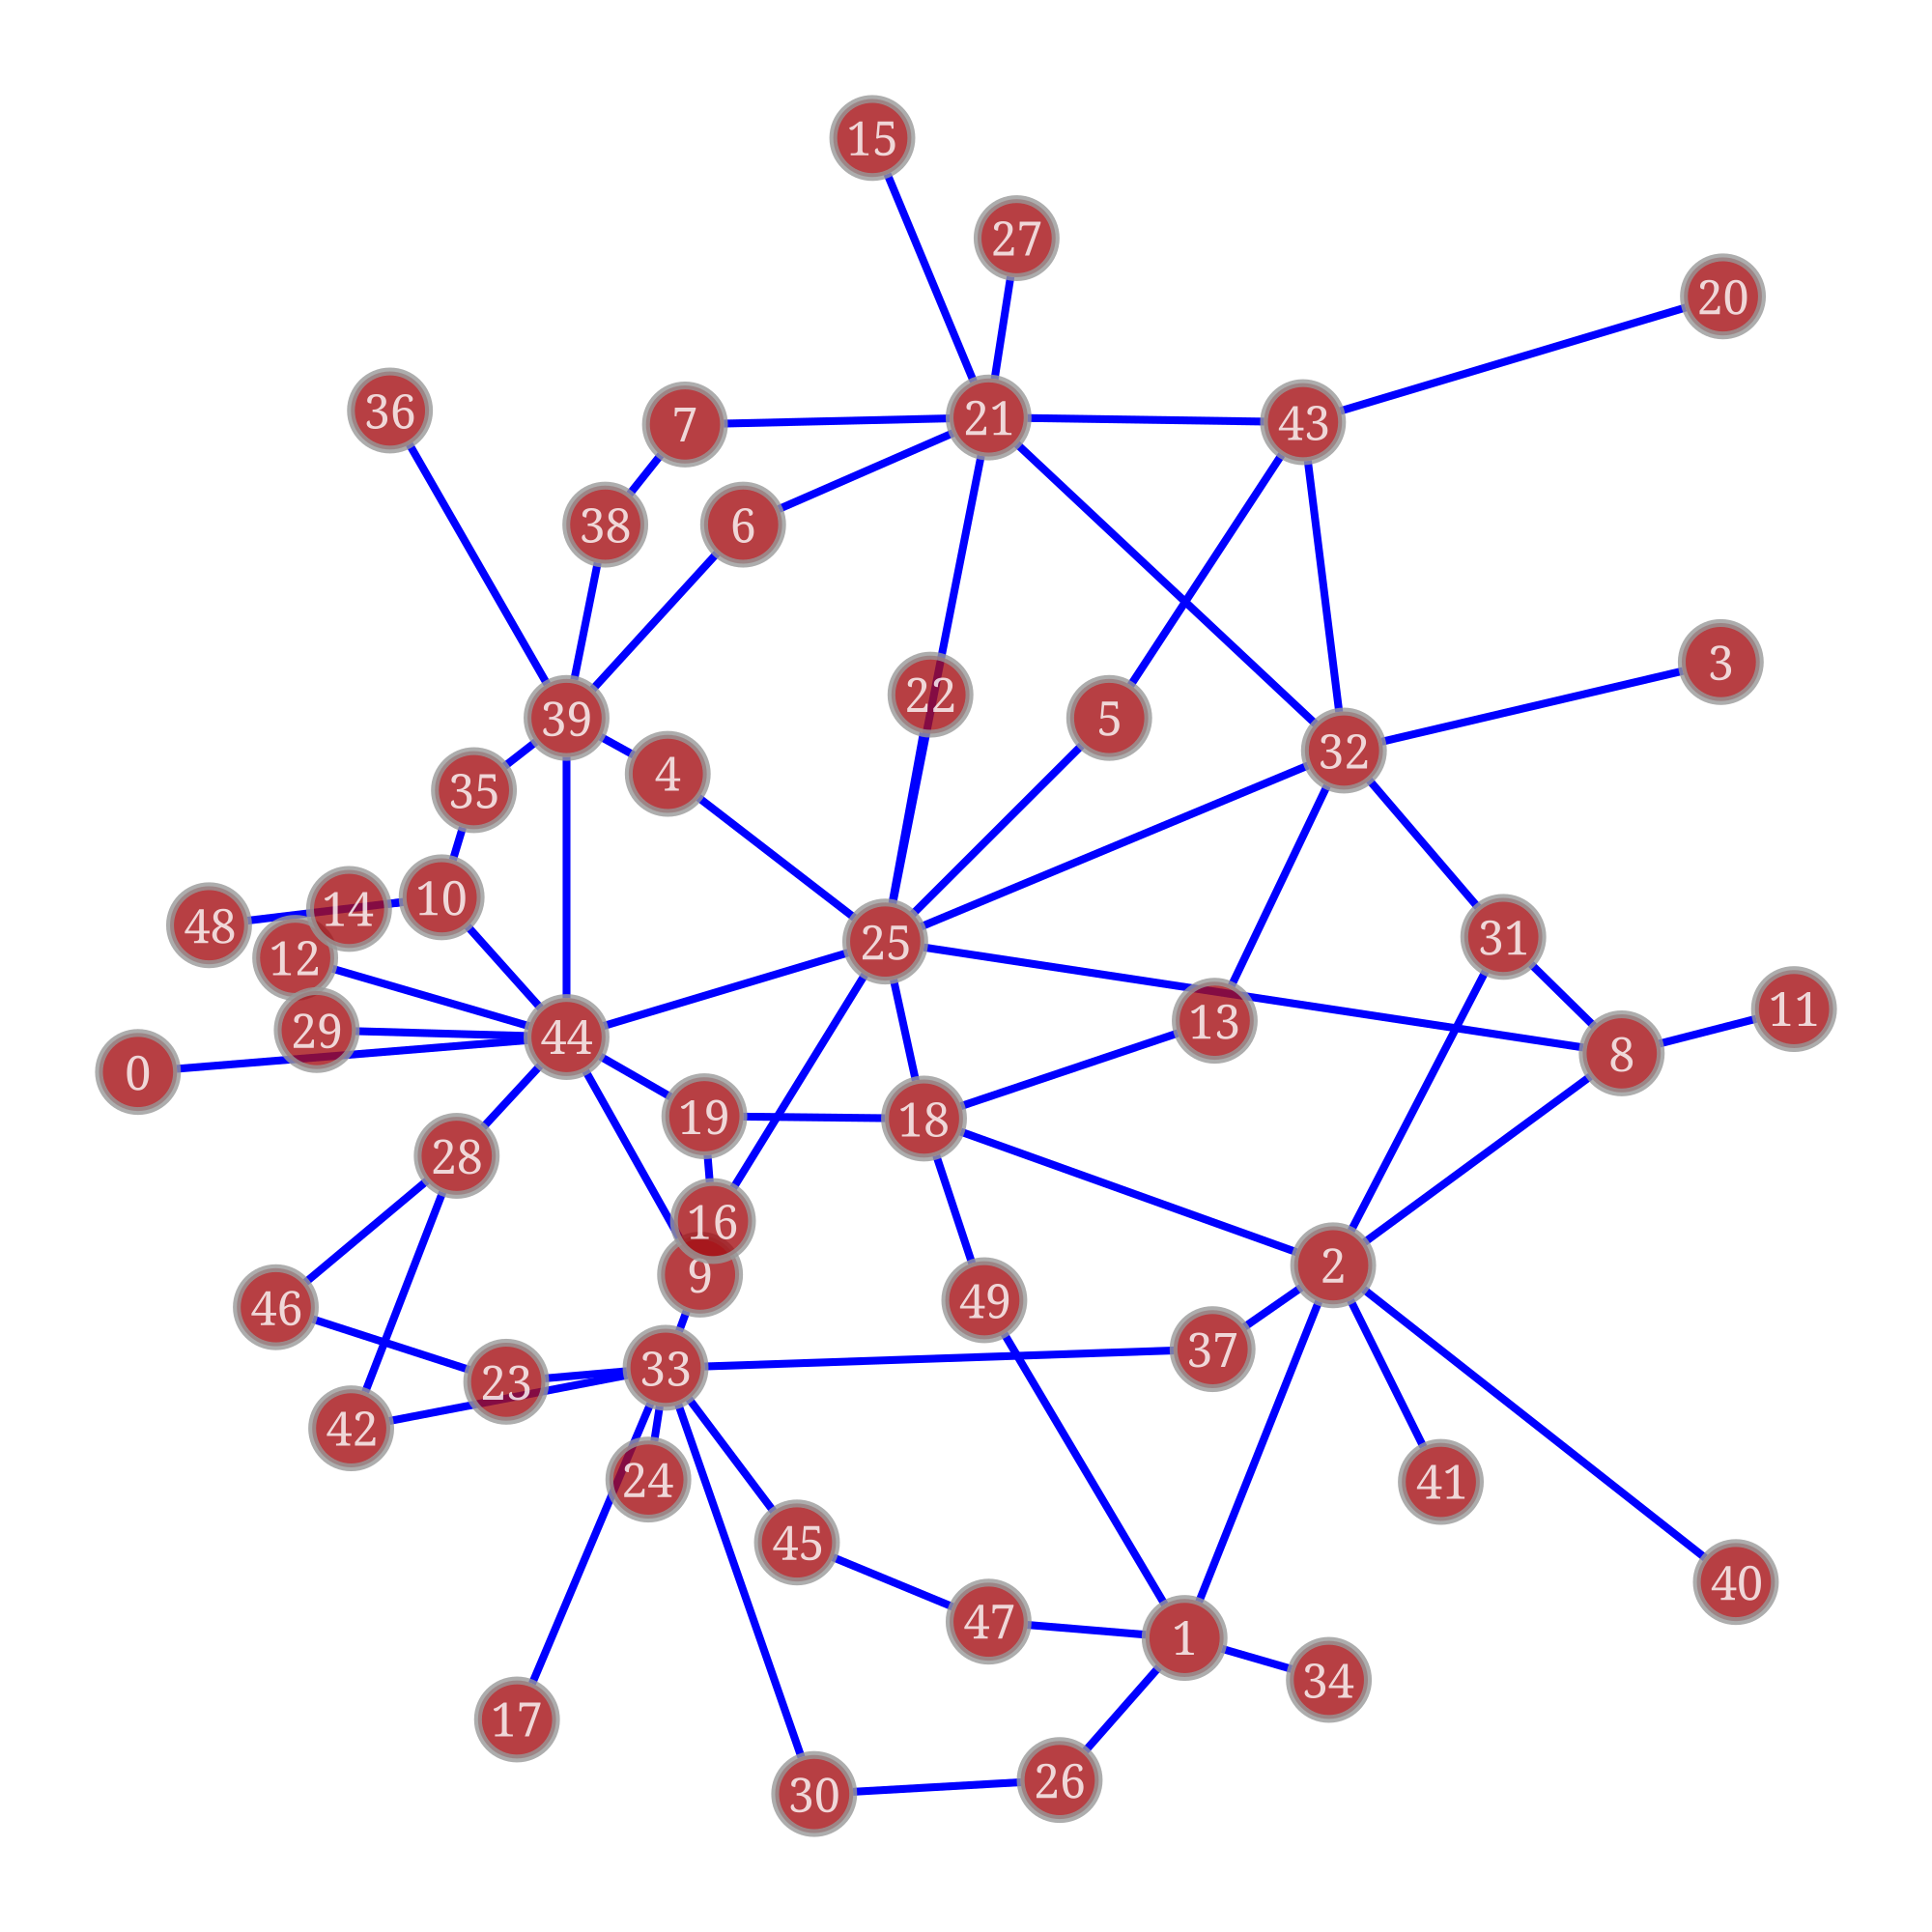

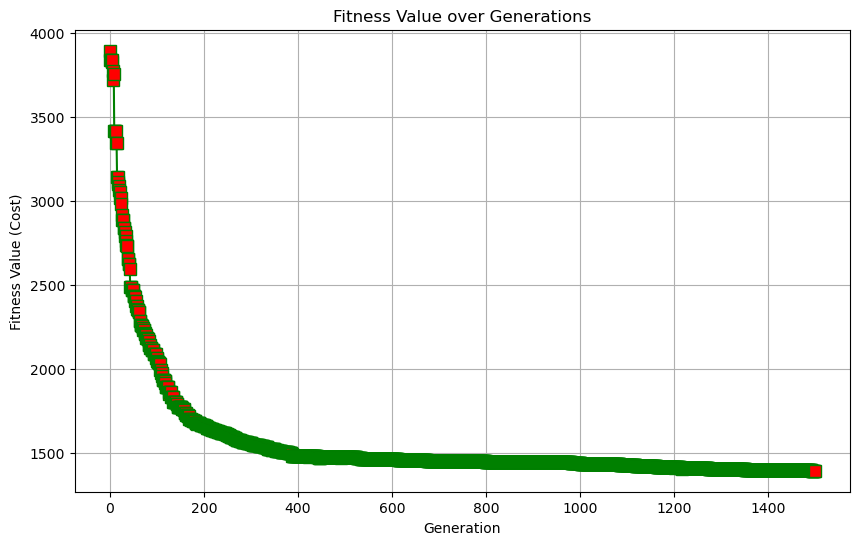

In [5]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()
print("nodes: ", read_graph.num_vertices(), "links ", num_edges)

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual

# 将个体解码为图并计算边权重属性　個体をグラフにデコードし、エッジの重みを計算する
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights

# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数为文件中边的数量
        return float('inf'),  # 如果边数不为文件中边的数量，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,

# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > num_edges:
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - num_edges)
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < num_edges:
            # 添加缺失的边
            missing_edges = random.sample(non_edges, num_edges - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2

# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边　エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边　エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,

# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

# 初始化个体时确保边数为文件中的边数量　初期個体を初期化する際にエッジ数をファイル中のエッジ数に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], num_edges)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)

toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)

# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main():
    population_size = 300
    num_selected = int(population_size * 2 / 3)
    num_offspring = population_size - num_selected
    num_generations = 1500
    cxpb, mutpb = 0.5, 0.2
    
    # 初始化种群
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(num_generations):
        # 选择操作：选择200个个体作为父代
        selected = toolbox.select(pop, num_selected)
        
        # 生成新的100个个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]
        
        # 组合父代和新生成的个体，形成新的种群
        pop[:] = selected + offspring
        
        # 评估新的种群
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        
        # 记录和输出每一代的最优适应度值
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

        # 更新Hall of Fame
        hof.update(pop)

    return pop, logbook, hof

if __name__ == "__main__":
    pop, logbook, hof = main()
    
    # 确保hof中有个体
    if len(hof) > 0:
        best_individual = hof[0]
        best_graph, _ = individual_to_graph(best_individual, read_graph.num_vertices())

        # 为每个节点标上对应的序号
        vertex_text = best_graph.new_vertex_property("string")
        for v in best_graph.vertices():
            vertex_text[v] = str(int(v))

        # 绘制最终优化后的图　最終的に最適化されたグラフを描画する
        graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000))
        graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000),
                   output=f'./output_O/{filename1}.png')

        # 绘制适应度值随迭代次数变化的图表
        min_fitness_values = logbook.select("min")
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(min_fitness_values)), min_fitness_values, marker='s', linestyle='-', color='g', markerfacecolor='r', markersize=8)
        plt.title("Fitness Value over Generations")
        plt.xlabel("Generation")
        plt.ylabel("Fitness Value (Cost)")
        plt.grid(True)
        plt.savefig(f"./output_O/fitness_over_generations.png")
        plt.show()
    else:
        print("No individuals in Hall of Fame.")
